In [1]:
##  Plots for the figure 2
# author:   Oleg Vinogradov 
# date:     15-02-2024

# Main points
# Check the invariances from the posterior, get points from 3 states
# generate spikes
# Notes: WIS-data-processing/WIS-data-processing.ipynb for data preprocessing
# and summary extraction

#
import sys
sys.path.remove('/home/ovinogradov/Projects/ReducedBursting')
# sys.path.remove('/home/ovinogradov/.local/lib/python3.9/site-packages')
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import linregress
import seaborn as sns
import sympy as sp

# model import 
from src.dynamics import StochSim_o
from sympy.plotting import plot as spplot
from src.helpers import getNull
from src.helpers import expand_params
from src.helpers import spike_burst_det

na =np.array

import numpy as np
import numpy as np
from scipy.io import loadmat as loadmat

# sbi import 
import torch
from sbi import utils as utils
from sbi import analysis as analysis
# Plotting 
plt.style.use('default')  
from src.vis.bifurcations import plot_bifurcations
from src.vis import styling_func
from src.vis.styling_func import to_inches

/home/ovinogradov/miniconda3/envs/NetBurstDynamics/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


AssertionError: 

In [3]:
import os
# Remove unwanted path from PATH
unwanted = "/home/ovinogradov/Projects/ReducedBursting"
os.environ['PATH'] = ':'.join([p for p in os.environ['PATH'].split(':') if p != unwanted])

In [6]:
os.environ['PATH']

'/home/ovinogradov/miniconda3/envs/NetBurstDynamics/bin:/home/ovinogradov/.vscode-server/cli/servers/Stable-4849ca9bdf9666755eb463db297b69e5385090e3/server/bin/remote-cli:/home/ovinogradov/miniconda3/envs/NetBurstDynamics/bin:/home/ovinogradov/miniconda3/condabin:/home/ovinogradov/.local/bin:/home/ovinogradov/.local/bin:/home/ovinogradov/.local/bin:/home/ovinogradov/.local/bin:/home/ovinogradov/.local/bin:/home/ovinogradov/.local/bin:/home/ovinogradov/.local/bin:/home/ovinogradov/.local/bin:/home/ovinogradov/.local/bin:/usr/local/sbin:/usr/local/bin:/usr/bin:/usr/lib/jvm/default/bin:/usr/bin/site_perl:/usr/bin/vendor_perl:/usr/bin/core_perl:/var/lib/snapd/snap/bin:/usr/local/texlive/2024/bin/x86_64-linux'

In [2]:
import sys
print(sys.executable)
print(sys.path)

/home/ovinogradov/miniconda3/envs/NetBurstDynamics/bin/python
['/home/ovinogradov/Projects/NetBurstDynamics/scripts/figures', '', '/home/ovinogradov/miniconda3/envs/NetBurstDynamics/lib/python39.zip', '/home/ovinogradov/miniconda3/envs/NetBurstDynamics/lib/python3.9', '/home/ovinogradov/miniconda3/envs/NetBurstDynamics/lib/python3.9/lib-dynload', '/home/ovinogradov/Projects/ReducedBursting', '/home/ovinogradov/miniconda3/envs/NetBurstDynamics/lib/python3.9/site-packages', '/home/ovinogradov/Projects/NetBurstDynamics', '/home/ovinogradov/.local/lib/python3.9/site-packages/IPython/extensions', '/home/ovinogradov/miniconda3/envs/NetBurstDynamics/lib/python3.9/site-packages/setuptools/_vendor', '/home/ovinogradov/.ipython']


In [6]:
import src

src.__file__

'/home/ovinogradov/Projects/ReducedBursting/src/__init__.py'

### Visualize preselected samples on a bifurcation diagram

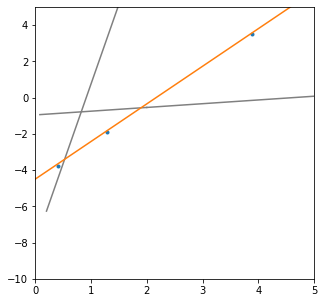

In [614]:
# Model paramters [b, theta, log tau_w, sigma]
samples = na([[ 0.415,  3.7552755 ,  9.950668  ,  1.47 ],
           [ 1.2901986 ,  1.8996212 , 10.953961  ,  1.47],
           [ 3.89 , -3.5054274 , 12.080247  ,  1.4754231 ]])
plt.figure(figsize=(5,5))
plot_bifurcations(inverse=1,color='k')
plt.plot(samples[:,0],-samples[:,1],'or')
plt.xlim([0,5])
plt.ylim([-10,5])
plt.xlabel('b')
plt.ylabel('$\\theta$')

In [598]:
# Generate activity

burst_detection_params={'maxISIstart':10.,
                    'maxISIb':10.,
                    'minBdur':20.,
                    'minIBI':20.,
                    'minSburst':7.,
                    'scale':10.
                    }
res = []

for i,ind in enumerate([0,1,2]):
    sampl = samples[i,:]#[sorted_ind[ind],:].numpy()
    params = expand_params(sampl,T=800000,torch_=False,keys=['b','theta','tau_w','sigma'])
    params['x0']=0
    t_dyn,x_dyn,w_dyn = StochSim_o(params,torch=0)
    res.append([t_dyn,x_dyn,w_dyn])
    cut = int(len(t_dyn)/4)
    dt= np.diff(t_dyn[cut::100])[0]    
    bursts= na(spike_burst_det(x_dyn[cut::100],dt,burst_detection_params))
    print(len(bursts))
    if len(bursts)>2:
        durs = np.diff(bursts)/1000
        ibis =(bursts[1:,0]-bursts[:-1,1])/1000
        mibi = np.mean(ibis)
        mdur = np.mean(durs)
        cv_ibis = np.std(ibis)/mibi
        print('----Bursts-----')
        print(mibi,cv_ibis,mdur)

42
----Bursts-----
10.89219512195122 0.5355040556415659 3.169166666666667
43
----Bursts-----
10.824285714285715 0.5440396576890579 3.2973255813953486
49
----Bursts-----
9.409479166666666 0.5281054386091754 2.85234693877551


# Generate Activity

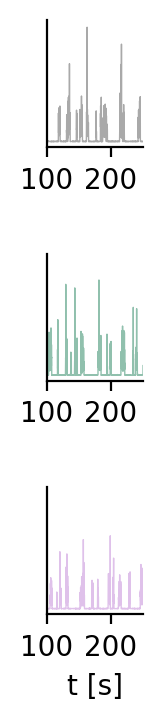

In [610]:
# plt.figure(figsize=(6.556/3,2.1),dpi=200)
# plt.subplot(1,3,3)
fig =plt.figure(figsize=(to_inches(10.2),to_inches(10.0)),dpi=200)
limits= [[7,14],[0,1],[2,4]]
labels= ['Inter-burst interval','CV of Inter-burst intervals','Burst duration']
gridspec = fig.add_gridspec(nrows=6, ncols=12,hspace=10)
axes = {}
axes['1'] = fig.add_subplot(gridspec[0:2, 0:2])
axes['2'] = fig.add_subplot(gridspec[2:4, 0:2])
axes['3'] = fig.add_subplot(gridspec[4:6, 0:2])
names = ['bis','exc','osc']
for i,m in enumerate(res): 
    t_dyn,x_dyn,w_dyn = m
    x_dyn = x_dyn[::2000]# binsize! 100ms
    spikes = np.random.poisson(np.exp(.6*x_dyn[:]))
    sc = sc
    axes[str(i+1)].plot(t_dyn[::2000]/1000,spikes,
                    color=styling_func.colours[names[i]],linewidth=0.5)
    axes[str(i+1)].set_xlim([100,250])
    # axes[str(i+1)].set_ylim([-10,1050])
    axes[str(i+1)].set_yticks([])
    sns.despine(ax=axes[str(i+1)])
    # plt.yticks([])
axes[str(i+1)].set_xlabel('t [s]')
plt.savefig('../../results/figs/paper_figs/example_traces.pdf')

## Visualize nullclines

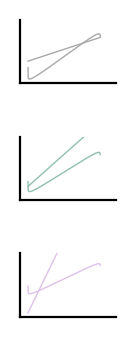

In [589]:

fig =plt.figure(figsize=(to_inches(10.2),to_inches(5.0)),dpi=200)
limits= [[7,14],[0,1],[2,4]]
labels= ['Inter-burst interval','CV of Inter-burst intervals','Burst duration']
gridspec = fig.add_gridspec(nrows=6, ncols=12,hspace=10)
axes = {}
axes['1'] = fig.add_subplot(gridspec[0:2, 0:2])
axes['2'] = fig.add_subplot(gridspec[2:4, 0:2])
axes['3'] = fig.add_subplot(gridspec[4:6, 0:2])
limits = [[-3.5,6.5],[-2.5,9],[-1,14]]
for i in range(3):
    # plt.subplot(3,1,i+1)
    # res[i]
    t_dyn,x_dyn,w_dyn = res[i]
    params = expand_params(samples[i],keys=['b', 'theta', 'tau_w','sigma'])
    # params = expand_params(samples[sorted_ind[sel[0]],:].numpy(),keys=['b', 'theta', 'tau_w','sigma'])

    x,w,w1 = getNull(params)

    xf = sp.lambdify(x,x)
    wf = sp.lambdify('x',w)
    w1f = sp.lambdify('x',w1)
    # x = np.arange(0.00001,9,0.000001)
    x = np.arange(0.00001,9,0.01)
    axes[str(i+1)].plot(x,wf(x),linewidth=0.5,color= styling_func.colours[names[i]])
    axes[str(i+1)].plot(x,w1f(x),linewidth=0.5,color= styling_func.colours[names[i]])
    axes[str(i+1)].set_xticks([])
    axes[str(i+1)].set_yticks([])
    
    # axes[str(i+1)].plot(x_dyn[1000000:1095000:1000],w_dyn[1000000:1095000:1000],'.',alpha=.34,
    #                     color= styling_func.colours[names[i]],markersize=0.1)
    sns.despine(ax= axes[str(i+1)])
    axes[str(i+1)].set_ylim(limits[i])
    axes[str(i+1)].set_xlim([-1,11])
    # w1f = sp.lambdify(w1,'x')
    

plt.savefig('../../results/figs/paper_figs/null_clines.pdf')

## Check the statistics of bursting


In [438]:
# check the statistics of bursting for different random
from src.helpers import simulator_summaryN as simulator
# num_dim = 4
# prior = utils.BoxUniform(low=torch.tensor([ .05,-1.,  np.log(200.), 0.1,])*torch.ones(num_dim),
                        #  high=torch.tensor([ 20.0, 15,  np.log(200000.),2.0])*torch.ones(num_dim))

def simulator2(params):
    param_set = params[:4]
    seed= int(params[4])
    return simulator(param_set,param_keys=['b','theta','tau_w','sigma'],
                                          burst_detection_params={'maxISIstart':10.,
                                                'maxISIb':10.,
                                                'minBdur':10.,
                                                'minIBI':10.,
                                                'minSburst':7.,#17.,
                                                'scale':10.},
                                                 seed=seed)
def batch_simulatior(theta: torch.Tensor): 
    """Return a batch of simulations by looping over a batch of parameters."""
    assert theta.ndim > 1, "Theta must have a batch dimension."
    xs = list(map(simulator2, theta))
    return torch.cat(xs, dim=0).reshape(theta.shape[0], -1)


parameters= []
for i in range(3):
    for j in range(200):
        p =  samples[i,:]#samples[sorted_ind[sel[i]],:].numpy()
        parameters.append(np.hstack([p,int(123456+j)]))

%time xs = simulate_in_batches(batch_simulatior,torch.tensor(parameters),sim_batch_size=1, num_workers=20)
xs_ = xs.numpy().copy()
xs_r = np.reshape(xs_,(3,200,6))

Running 600 simulations in 600 batches.:   0%|          | 0/600 [00:00<?, ?it/s]

CPU times: user 3.33 s, sys: 339 ms, total: 3.67 s
Wall time: 4min 15s


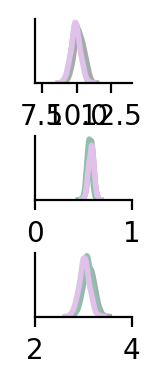

In [511]:
fig =plt.figure(figsize=(to_inches(10.2),to_inches(5.0)),dpi=200)
limits= [[7,14],[0,1],[2,4]]
labels= ['Inter-burst interval','CV of Inter-burst intervals','Burst duration']
gridspec = fig.add_gridspec(nrows=6, ncols=12,hspace=10)
axes = {}
axes['1'] = fig.add_subplot(gridspec[0:2, 0:2])
axes['2'] = fig.add_subplot(gridspec[2:4, 0:2])
axes['3'] = fig.add_subplot(gridspec[4:6, 0:2])
for i in range(3):
    # plt.subplot(3,1,i+1)
    # plt.plot(xs_[:,i],'o')
    # plt.ylim(limits[i])
    # plt.axhline(x_0[i])

    sns.kdeplot(xs_r[0,:,i],color=styling_func.colours[names[0]],linewidth=2,ax=axes[str(i+1)])
    sns.kdeplot(xs_r[1,:,i],color=styling_func.colours[names[1]],linewidth=2,ax=axes[str(i+1)])
    sns.kdeplot(xs_r[2,:,i],color=styling_func.colours[names[2]],linewidth=2,ax=axes[str(i+1)])
    axes[str(i+1)].set_xlim(limits[i])
    axes[str(i+1)].set_ylabel(labels[i],fontsize=8)
    sns.despine(ax=axes[str(i+1)])
    axes[str(i+1)].set_yticks([])
# plt.tight_layout()
# plt.savefig('../../results/figs/paper_figs/Equal_dist.pdf')